# Perform VGG16 + CNN using Keras for 13x classes over AWS


In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from PIL import ImageFile
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
import itertools
import h5py


/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Functions for lots later

In [2]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(16,16), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Image preparation

In [4]:
train_path = 'dataset/training_set'
valid_path = 'dataset/validation_set'
test_path = 'dataset/test_set'

In [5]:
# Define batches
# ImageDataGenerator() is a keras object which generates batches of tensor image data.
# flow_from_directory is where you tell keras where is your images, and their labels.
# flow_from_directory also turns the labels to one-hot-encoded based. chopper=[0,0,1,0...0], clock=[1,0,0...0] 
# In this case we assigned 128x128 only because it yields a better result.
# If using VGG16, we had to change to 224x224, because VGG16 takes this size as inputs.
# If you are working on different classes such as xray images, a different size may be apply to achieve better result.
# This is a trail and error thing.

train_batches = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True).flow_from_directory(train_path, target_size = (224, 224), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                                   batch_size = 20)
valid_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(valid_path, target_size = (224, 224), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                         batch_size = 20)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224, 224), 
                                                         classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                                                         batch_size = 130)

Found 14970 images belonging to 13 classes.
Found 2593 images belonging to 13 classes.
Found 130 images belonging to 13 classes.


We put batch size 20. This is the number of images we will be grabbing for iteration.

In [6]:
# Every time we run this, a next sets of 20 images.
imgs, labels = next(train_batches)

In [7]:
# below are 1x batch, here are the lables.
labels

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 

In [8]:
len(imgs)

20

In [9]:
imgs

array([[[[0.0508761 , 0.17286192, 0.3820818 ],
         [0.05082949, 0.17300174, 0.38225266],
         [0.05078289, 0.17314155, 0.38242358],
         ...,
         [0.10228209, 0.15486261, 0.329815  ],
         [0.10200246, 0.15470725, 0.32908484],
         [0.10172284, 0.1545519 , 0.32835475]],

        [[0.07281363, 0.21264403, 0.41410682],
         [0.07296897, 0.21281491, 0.41421556],
         [0.07312433, 0.2129858 , 0.4143243 ],
         ...,
         [0.06432684, 0.17899759, 0.33889273],
         [0.06428023, 0.17930828, 0.33957627],
         [0.06423362, 0.179619  , 0.34025982]],

        [[0.04874729, 0.15740016, 0.33096227],
         [0.04851426, 0.15696518, 0.33038747],
         [0.04828123, 0.1565302 , 0.32981268],
         ...,
         [0.05076966, 0.18145733, 0.37531155],
         [0.05070752, 0.18119322, 0.37496978],
         [0.05064538, 0.18092912, 0.374628  ]],

        ...,

        [[0.03940498, 0.07450981, 0.20094648],
         [0.03943605, 0.07450981, 0.20110181]

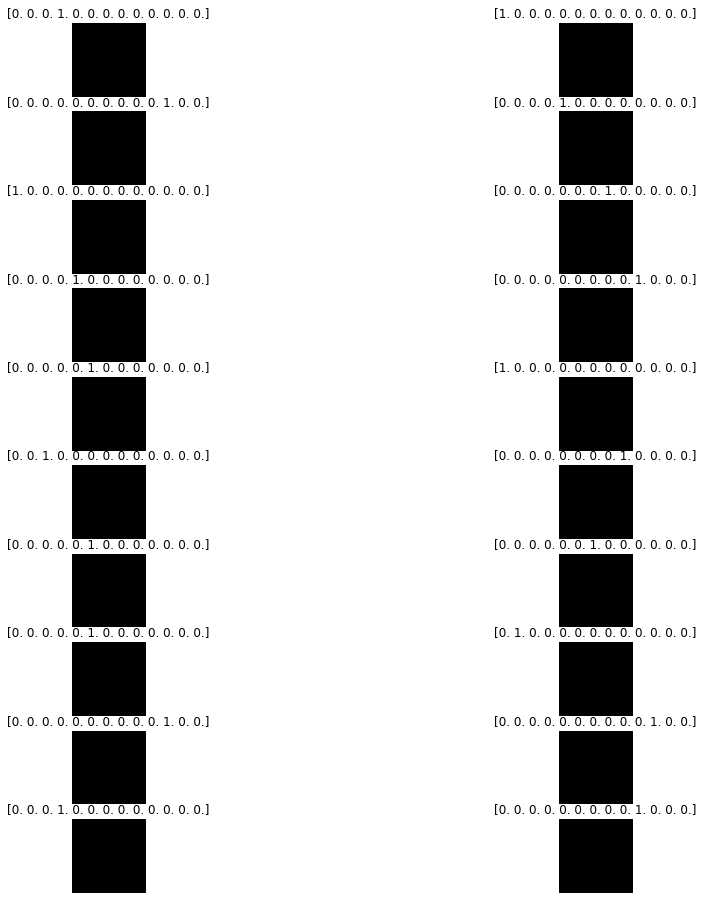

In [10]:
# Batches of 20
plots(imgs, titles = labels)

In [11]:
train_batches.class_indices

{'chopper': 0,
 'clock': 1,
 'frying_pan': 2,
 'knife': 3,
 'massage_chair': 4,
 'microwave': 5,
 'pots': 6,
 'rice_cooker': 7,
 'scissors': 8,
 'stools': 9,
 'swing': 10,
 'wine_cooler': 11,
 'wine_glass': 12}

#### prepare csv to save training logs

In [12]:
# Training with callbacks
from keras import callbacks

filename='vgg16_training_logs.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)


# filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

# Bulid VGG16 + CNN model

In [13]:
vgg16_model = keras.applications.vgg16.VGG16()

In [14]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
type(vgg16_model)

keras.engine.training.Model

In [16]:
classifier = Sequential()
for layer in vgg16_model.layers:
    classifier.add(layer)

In [17]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
type(classifier)

keras.models.Sequential

In [19]:
classifier.layers.pop()

In [20]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
#freeze the top layers
for layer in classifier.layers:
    layer.trainable = False

In [22]:
classifier.add(Dense(units = 13, activation = 'softmax'))  # 13 classes

In [23]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
classifier.compile(optimizer=optimizers.SGD(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [25]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Training starts NOW!!

In [28]:
# steps_per_epoch =  no. of images /  batch_no.
classifier.fit_generator(train_batches, steps_per_epoch = 20, 
                         validation_data = valid_batches, validation_steps = 20, 
                         epochs = 100, verbose = 2, callbacks=callbacks_list)

Epoch 1/100
 - 127s - loss: 2.5630 - acc: 0.0875 - val_loss: 2.5630 - val_acc: 0.0475
Epoch 2/100
 - 127s - loss: 2.5629 - acc: 0.0675 - val_loss: 2.5630 - val_acc: 0.0500
Epoch 3/100
 - 126s - loss: 2.5620 - acc: 0.0725 - val_loss: 2.5629 - val_acc: 0.0500
Epoch 4/100
 - 126s - loss: 2.5623 - acc: 0.0850 - val_loss: 2.5628 - val_acc: 0.0500
Epoch 5/100
 - 126s - loss: 2.5617 - acc: 0.0700 - val_loss: 2.5627 - val_acc: 0.0600
Epoch 6/100
 - 127s - loss: 2.5617 - acc: 0.0925 - val_loss: 2.5627 - val_acc: 0.0625
Epoch 7/100
 - 127s - loss: 2.5622 - acc: 0.0925 - val_loss: 2.5626 - val_acc: 0.0650
Epoch 8/100
 - 125s - loss: 2.5611 - acc: 0.0575 - val_loss: 2.5625 - val_acc: 0.0625
Epoch 9/100
 - 127s - loss: 2.5608 - acc: 0.1150 - val_loss: 2.5624 - val_acc: 0.0650
Epoch 10/100
 - 126s - loss: 2.5607 - acc: 0.1150 - val_loss: 2.5624 - val_acc: 0.0675
Epoch 11/100
 - 126s - loss: 2.5614 - acc: 0.0700 - val_loss: 2.5623 - val_acc: 0.0700
Epoch 12/100
 - 127s - loss: 2.5609 - acc: 0.1075 - 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 - 126s - loss: 2.5599 - acc: 0.1050 - val_loss: 2.5621 - val_acc: 0.0900
Epoch 14/100
 - 126s - loss: 2.5606 - acc: 0.1075 - val_loss: 2.5621 - val_acc: 0.0900
Epoch 15/100
 - 126s - loss: 2.5602 - acc: 0.0925 - val_loss: 2.5620 - val_acc: 0.1050
Epoch 16/100
 - 127s - loss: 2.5579 - acc: 0.1450 - val_loss: 2.5619 - val_acc: 0.1150
Epoch 17/100
 - 126s - loss: 2.5564 - acc: 0.1850 - val_loss: 2.5618 - val_acc: 0.1350
Epoch 18/100
 - 126s - loss: 2.5584 - acc: 0.1475 - val_loss: 2.5617 - val_acc: 0.1425
Epoch 19/100
 - 126s - loss: 2.5600 - acc: 0.1275 - val_loss: 2.5617 - val_acc: 0.1450
Epoch 20/100
 - 127s - loss: 2.5592 - acc: 0.1350 - val_loss: 2.5616 - val_acc: 0.1450
Epoch 21/100
 - 126s - loss: 2.5579 - acc: 0.1775 - val_loss: 2.5615 - val_acc: 0.1500
Epoch 22/100
 - 126s - loss: 2.5569 - acc: 0.1700 - val_loss: 2.5614 - val_acc: 0.1500
Epoch 23/100
 - 126s - loss: 2.5576 - acc: 0.1600 - val_loss: 2.5614 - val_acc: 0.1475
Epoch 24/100
 - 127s - loss: 2.5579 - acc: 0.1600 - val_

# Save weights and model to a h5 file 

This save functions saves:
    - The architecture of the model, allowing to re-create the model.
    - The weights of themodel.
    - The training configuraton (loss, optimaizer)
    - The state of the optimizer, allowing to resume training exactly where you left off

In [29]:
classifier.save('vgg16_best_weights.h5')

In [30]:
model_json = classifier.to_json()
with open("vgg16_model.json","w") as json_file:
    json_file.write(model_json)

In [32]:
classifier.save_weights("vgg16_weights.h5")

#### Load saved model

In [ ]:
from keras.models import load_model
new_model = load_model('vgg16_best_weights.h5')

In [ ]:
# This will load the same table.
new_model.summary() 

In [ ]:
# To check what optimizer did we used?
new_model.optimizer

In [ ]:
# To pull out the trained weight
# new_model.get_weights()

# Prediction

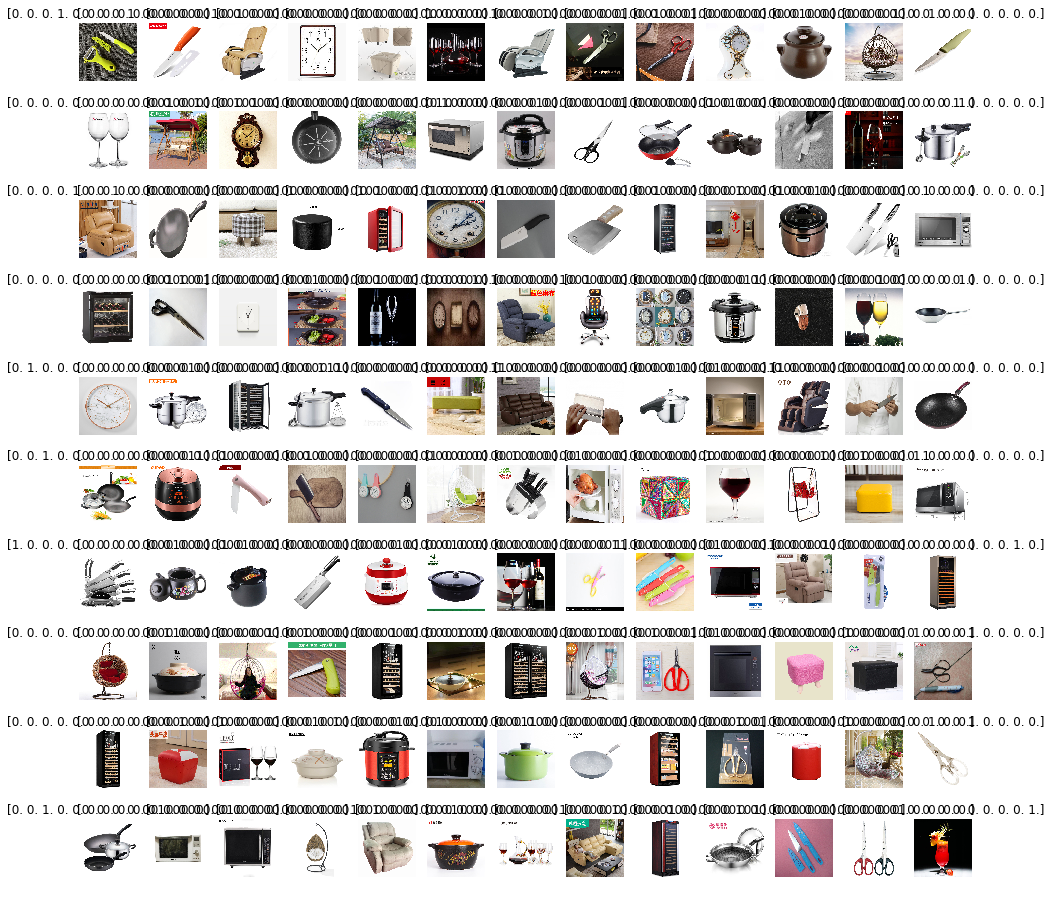

In [33]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [34]:
test_labels_1 = test_labels[:,12]
test_labels_1

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [35]:
pred = classifier.predict_generator(test_batches, steps=1, verbose=0)

In [36]:
#checks
len(pred)

130

In [37]:
#checks
np.argmax(pred, axis=1)

array([ 8,  8,  5,  0,  5,  1,  5,  8,  0,  0,  5,  0,  0,  5, 12,  0,  9,
       12,  5,  5,  0,  5,  9,  5,  8,  5, 12,  0,  9, 12,  1,  0,  0,  0,
        0,  1, 12,  0,  5,  0, 12,  9,  5,  5,  0, 12, 12, 12,  5,  5,  1,
        5,  9,  5,  9,  5,  0, 12, 12,  1,  0,  8,  5,  1,  1,  5,  0,  0,
        1,  9, 10,  0,  5,  1,  5, 12,  0,  8,  1, 12,  0,  8,  5,  0,  5,
        1,  5, 12, 12,  8,  0,  8,  0, 10,  8,  8,  5,  8, 10,  5, 12,  1,
        1,  0,  8,  1,  5,  9, 12,  8,  0,  5, 12,  0, 12, 10,  8,  5,  8,
       12,  8,  1,  0,  8, 12,  0,  5,  0,  0,  1])

In [38]:
# checks
test_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

#### Confusion Matrix

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred, axis=1))
np.set_printoptions(precision=2)
cnf_matrix

array([[4, 4, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [5, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1],
       [1, 1, 0, 0, 0, 7, 0, 0, 0, 1, 0, 0, 0],
       [4, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6],
       [0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 3],
       [5, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1],
       [2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2],
       [5, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1],
       [1, 4, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3],
       [1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 3],
       [4, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1],
       [0, 3, 0, 0, 0, 5, 0, 0, 2, 0, 0, 0, 0]])

Confusion matrix, without normalization
[[4 4 0 0 0 1 0 0 1 0 0 0 0]
 [5 1 0 0 0 0 0 0 0 3 0 0 1]
 [1 1 0 0 0 7 0 0 0 1 0 0 0]
 [4 0 0 0 0 2 0 0 4 0 0 0 0]
 [0 1 0 0 0 3 0 0 0 0 0 0 6]
 [0 0 0 0 0 3 0 0 4 0 0 0 3]
 [5 0 0 0 0 2 0 0 0 2 0 0 1]
 [2 0 0 0 0 6 0 0 0 0 0 0 2]
 [5 1 0 0 0 1 0 0 2 0 0 0 1]
 [1 4 0 0 0 1 0 0 0 1 0 0 3]
 [1 0 0 0 0 0 0 0 2 0 4 0 3]
 [4 1 0 0 0 0 0 0 3 1 0 0 1]
 [0 3 0 0 0 5 0 0 2 0 0 0 0]]


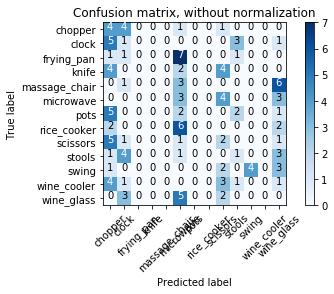

In [40]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['chopper','clock','frying_pan','knife','massage_chair','microwave',
                                                                  'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass'],
                      title='Confusion matrix, without normalization')

#### Classification report

In [41]:
classes=['chopper','clock','frying_pan','knife','massage_chair','microwave', 'pots','rice_cooker','scissors','stools','swing','wine_cooler','wine_glass']
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(pred, axis=1),target_names=classes))

               precision    recall  f1-score   support

      chopper       0.12      0.40      0.19        10
        clock       0.06      0.10      0.08        10
   frying_pan       0.00      0.00      0.00        10
        knife       0.00      0.00      0.00        10
massage_chair       0.00      0.00      0.00        10
    microwave       0.10      0.30      0.15        10
         pots       0.00      0.00      0.00        10
  rice_cooker       0.00      0.00      0.00        10
     scissors       0.11      0.20      0.14        10
       stools       0.12      0.10      0.11        10
        swing       1.00      0.40      0.57        10
  wine_cooler       0.00      0.00      0.00        10
   wine_glass       0.00      0.00      0.00        10

  avg / total       0.12      0.12      0.10       130



/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LIVE Demo image prediction

In [42]:
train_batches.class_indices

{'chopper': 0,
 'clock': 1,
 'frying_pan': 2,
 'knife': 3,
 'massage_chair': 4,
 'microwave': 5,
 'pots': 6,
 'rice_cooker': 7,
 'scissors': 8,
 'stools': 9,
 'swing': 10,
 'wine_cooler': 11,
 'wine_glass': 12}

In [43]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [45]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 224, 224

# load the model we saved
model = load_model('vgg16_best_weights.h5')
model.compile(optimizer=optimizers.SGD(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# predicting images
img = image.load_img('./dataset/test_set/chopper/64236.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)

plots(images, titles=test_labels)
listclass = list(train_batches.class_indices.keys())
print('Predict below item is a : ', listclass[classes[0]]) 

ValueError: Dimension 0 in both shapes must be equal, but are 4096 and 1000. Shapes are [4096,13] and [1000,13]. for 'Assign_93' (op: 'Assign') with input shapes: [4096,13], [1000,13].